# Gyroscope DDPG reward function testing (spinup library)

In [7]:
import gym
from gym import spaces
from gym.utils import seeding
import numpy as np
from os import path
from scipy.integrate import solve_ivp
import pandas as pd

import gym_gyroscope_env
import spinup
import torch
from functools import partial

from custom_functions.custom_functions import env_fn 
from custom_functions.custom_functions import create_env
from custom_functions.custom_functions import load_agent
from custom_functions.custom_functions import test_agent
from custom_functions.custom_functions import plot_test
from custom_functions.custom_functions import evaluate_control
from custom_functions.custom_functions import read_progress

import random
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline
import pickle

# Print weight to generate shared object (.so) file

In [63]:
path = 'iter2_reward01/pyt_save/model.pt'
ac = torch.load(path)

In [64]:
# List all NN parameters
for param in ac.pi.pi.parameters():
    print(type(param), param.size())
params = list(ac.parameters())
pi_w1 = params[0].detach().numpy()
pi_b1 = params[1].detach().numpy()
pi_w2 = params[2].detach().numpy()
pi_b2 = params[3].detach().numpy()
pi_w3 = params[4].detach().numpy()
pi_b3 = params[5].detach().numpy()

<class 'torch.nn.parameter.Parameter'> torch.Size([128, 9])
<class 'torch.nn.parameter.Parameter'> torch.Size([128])
<class 'torch.nn.parameter.Parameter'> torch.Size([32, 128])
<class 'torch.nn.parameter.Parameter'> torch.Size([32])
<class 'torch.nn.parameter.Parameter'> torch.Size([2, 32])
<class 'torch.nn.parameter.Parameter'> torch.Size([2])


In [56]:
# np.savetxt('pi_w1.csv', pi_w1, delimiter=',')
# np.savetxt('pi_b1.csv', pi_b1, delimiter=',')
# np.savetxt('pi_w2.csv', pi_w2, delimiter=',')
# np.savetxt('pi_b2.csv', pi_b2, delimiter=',')
# np.savetxt('pi_w3.csv', pi_w3, delimiter=',')
# np.savetxt('pi_b3.csv', pi_b3, delimiter=',')

In [69]:
w = pi_w3
for i in range(len(w)):
    print('{',end='')
    for j in range(len(w[0])-1):
        print(w[i][j],end=',')
    print(w[i][-1],end='')
    print('},')

{-0.010034241,1.143093,-0.028274538,-2.0026565,0.26051998,0.0031288902,-0.8578863,-0.0035489749,0.042123105,0.0030650923,0.00048233822,0.0053407876,-1.3902497,-0.22208712,-0.0035619782,-0.0007443807,3.3359458,-0.00021860379,-0.00084920065,-0.002736527,-0.0046883514,0.021008631,0.19846769,-0.003117895,-0.005485875,0.002033555,0.7492839,-0.0048132115,0.0038272873,-0.7566507,-0.00031670922,-0.0013577279},
{-0.84634185,0.0031060183,-0.0016179177,-2.6044557,0.0080851205,-0.18797055,0.0006792346,0.32212493,-5.4255753,-0.40754235,0.1330779,-0.19268788,-2.8050096,0.0013187181,0.17112242,-0.1783874,-1.8847618,-0.30005145,-0.2562834,0.16075678,0.39946878,0.035374448,-0.00018194884,-0.109624185,0.17883918,-0.13954812,0.0033338582,-0.09839514,-0.34318998,-0.005398649,0.1581151,0.1371369},


In [70]:
b = pi_b3
print('{',end='')
for i in range(len(b)-1):
    print(b[i],end=',')
print(b[-1],end='')
print('}')

{0.014581948,0.0022389654}


# Gyro data

In [24]:
def read_data(filepath):
    
    # count lines
    file = open(filepath, "r")
    count = len(file.readlines())
    data = np.empty([count, 16])
    file.seek(0)
    
    # read each line as a numpy array
    row = 0
    for x in file:
        data[row] = np.array(x.split('\t')).astype(np.float)
        row += 1
    file.close()
    
    # change time from usec into sec and shift the beginning to 0
    data[:,11] = data[:,11] / 1e6
    data[:,11] -= data[0,11]
    
    return data

def angle_normalize(x, lim = np.pi):
    return ((x + lim) % (2 * lim)) - lim 

def plot_data(data):
    
    f, axs = plt.subplots(2,2,figsize=(14,7))

    plt.subplot(2,2,1)
    plt.title('Red gimbal angle',fontsize=20)
    plt.xlabel('time [s]',fontsize=16)
    plt.ylabel(r'$\theta$ [deg]',fontsize=16)
    plt.grid()
    plt.plot(data[:,11], data[:,14])
    plt.plot(data[:,11], angle_normalize(data[:,2],180))

    plt.subplot(2,2,2)
    plt.title('Blue gimbal angle',fontsize=20)
    plt.xlabel('time [s]',fontsize=16)
    plt.ylabel(r'$\theta$ [deg]',fontsize=16)
    plt.grid()
    plt.plot(data[:,11], data[:,15])
    plt.plot(data[:,11], angle_normalize(data[:,4],180))
    
    plt.subplot(2,2,3)
    plt.title('Red gimbal velocity',fontsize=20)
    plt.xlabel('time [s]',fontsize=16)
    plt.ylabel(r'$\dot(\theta)$ [rpm]',fontsize=16)
    plt.grid()
    plt.plot(data[:,11], data[:,3])

    plt.subplot(2,2,4)
    plt.title('Blue gimbal velocity',fontsize=20)
    plt.xlabel('time [s]',fontsize=16)
    plt.ylabel(r'$\dot(\theta)$ [rpm]',fontsize=16)
    plt.grid()
    plt.plot(data[:,11], data[:,5])

In [25]:
folderpath = 'gyro_data/'
filepaths = ['m0_ep001-010','m0_ep011-020','m0_ep021-030','m0_ep031-040','m0_ep041-050']
filepaths = ['m1_ep001-010','m1_ep011-020','m1_ep021-030','m1_ep031-040','m1_ep041-050']
filepath = folderpath+filepaths[0]

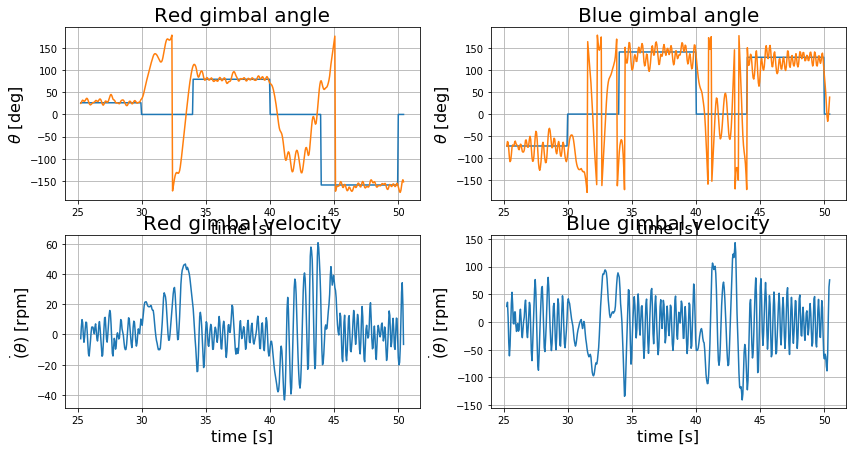

In [28]:
data = read_data(filepath+'.txt')
data = data[500:1000]
plot_data(data)

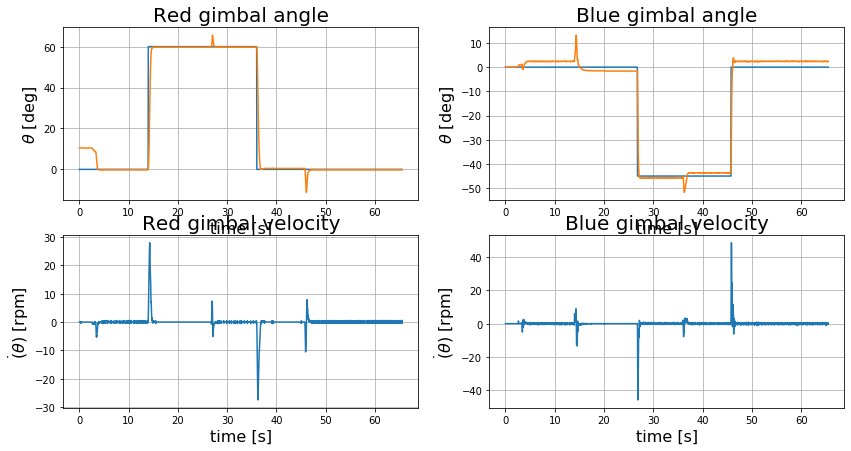

In [10]:
data = read_data(folderpath+filepaths[0]+'.txt')
plot_data(data)

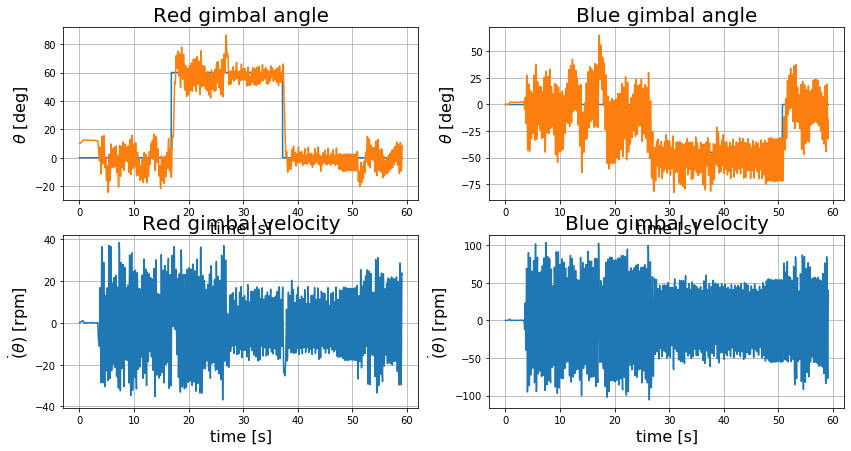

In [11]:
data = read_data(folderpath+filepaths[1]+'.txt')
plot_data(data)

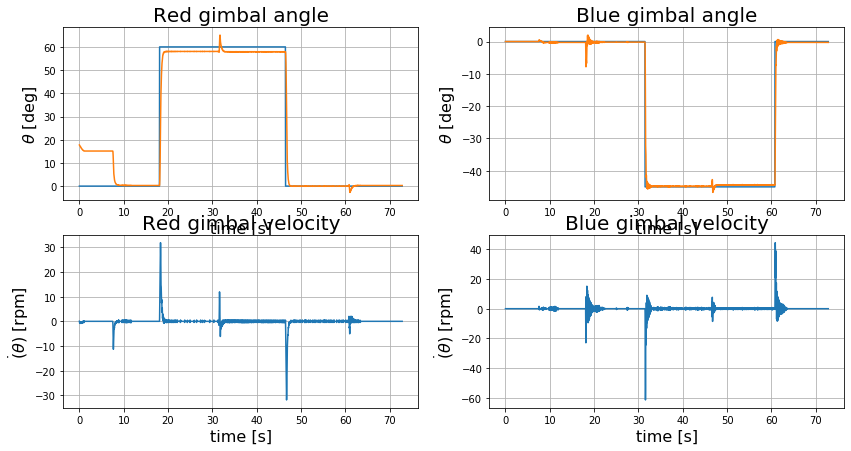

In [12]:
data = read_data(folderpath+filepaths[2]+'.txt')
plot_data(data)

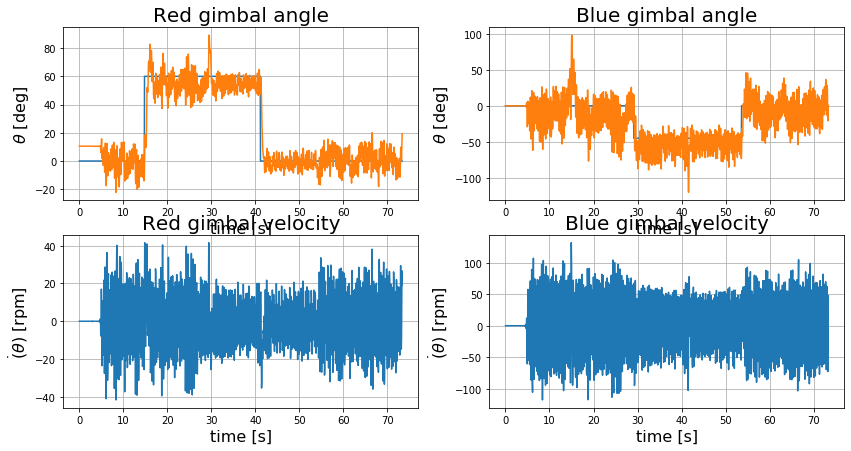

In [13]:
data = read_data(folderpath+filepaths[3]+'.txt')
plot_data(data)